# Applied Machine Learning

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.learning_curve import learning_curve
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline

### Import and preprocess data

In [2]:
data = pd.read_csv("CrowdstormingDataJuly1st.csv")

In [3]:
# Drop the rows for which we don't have the skin color (photoID = NaN)
photoIDNaN = data[pd.isnull(data['photoID'])].index.values
data = data.drop(data.index[[photoIDNaN]],axis=0)

# Drop unintersting columns
dataSkin = data.drop(data.columns[[1,4,16,17,18,19,20,21,23,24,26,27]], axis=1)
dataSkin.head()

,playerShort,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,meanIAT,meanExp
0,lucas-wilchez,Real Zaragoza,Spain,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,0.326391,0.396000
1,john-utaka,Montpellier HSC,France,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,0.203375,-0.204082
5,aaron-hughes,Fulham FC,England,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,0.325185,0.538462
6,aleksandar-kolarov,Manchester City,England,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,0.325185,0.538462
7,alexander-tettey,Norwich City,England,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,0.325185,0.538462


## Exercise 1: Predict player skin color using Random Forest Classifier

Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color.

Define y, the labels to be predicted. In our case this corresponds to skin color. 
These values are calculated as the average between the skin color ratings of the two judges. However we want to discard players for which the rating differes significantly between the two raters as this might bias our classifier. For this, we calculate the standard deviation of the rated skin color and discard those for which it is superior to 0.25.

In [4]:
# Define the value to be predicted: skin color 
y = np.mean([np.array(data.rater1), np.array(data.rater2)],axis = 0) # y are our classification labels

#Compute the standard deviation of the two judges
y_std=np.std([np.array(data.rater1), np.array(data.rater2)],axis = 0)

# Add this information to our dataframe
dataSkin['output'] = y
dataSkin['output_std']=y_std

#drop the lines when the raters didn't agree
print(sum(y_std>=0.25)) # For 164 samples, the raters differ significantly
dataSkin=dataSkin.drop(data.index[y_std>=0.25], axis=0)


data.head()

164


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


### Define X (features)

We group the data per player. We have to aggregate the different data we have for each player.
For their weight, height and the racial bias of their judge we want the mean across all judges.
For the club, league country and position we want the most common element. 
For the games, victories, ties, defeats, goals and the 3 types of card we want the sum across all judges (hence all games) 

In [5]:
#columns for which we want the sum of all scores
data_sum=dataSkin[['playerShort','games','victories','ties','defeats','goals','yellowCards','yellowReds','redCards']].groupby(['playerShort']).sum()

Processing "position" information. Some players have missing position information (i.e. NaN) in the data set. We would like to check if this informtion is available for any of the dyads of a given player, even if it is not present in all of them. If it is present, the idea was to replace it by the found value. However we found that for a given player, the position was either present in all of the dyads or not present in any of them. For this reason, we decided to create a position category called "none", meaning that we do not know their positions, in order to avoid discarding excessive incomplete data. 

In [6]:
# get the players that have some NaN in the position
position_nan=list(set(dataSkin.playerShort[dataSkin.position.isnull()]))
# there are 152 of them (len(position_nan))

# if in some rows we have an information about the position, we would like to keep it
# check if we have the position in some rows for these players: check for all the 152 players
for i in range(len(position_nan)):
    #if one row has something else than a none, print the index of the player
    if sum(dataSkin.position[dataSkin['playerShort']==position_nan[i]].notnull()) !=0:
        print(i)

In [7]:
# columns for which we want the most common element
# first change the nan in the position column into a string: 'none'
# usefull for grouping by most common element
dataSkin.position[dataSkin.position.isnull()]='none'
data_common=dataSkin[['playerShort','club','leagueCountry','position']].groupby(['playerShort']).agg(lambda x: x.value_counts().index[0])

C:\Users\Maria\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
#columns for which we want the mean
data_mean=dataSkin[['playerShort','height','weight', 'output','meanIAT','meanExp']].groupby(['playerShort']).mean()

#### Feature engineering

Based on the provided features, we tried to create features that could eventually carry more meaningful information to predict the skin color. In particular, we combined information about the number of cards that a player recieved and the racial bias of its referees. Specifically, we defined our featuers as the multiplication between the number of cards received by each player and the racial bias of the referees that gave the cards, and dividied this by the total number of cards. The features we created tried to reflect the fairness or unfairness of the number of cards delivered to a player.


In [9]:
# create columns to ponderate the racial bias of the judges with the number of red, yellow and yellow red cards they gave to each player
dataSkin['yellow_IAT']=dataSkin['meanIAT']*dataSkin['yellowCards']
dataSkin['red_IAT']=dataSkin['meanIAT']*dataSkin['redCards']
dataSkin['yellowred_IAT']=dataSkin['meanIAT']*dataSkin['yellowReds']

# do the same thing for explicit bias score
dataSkin['yellow_Exp']=dataSkin['meanExp']*dataSkin['yellowCards']
dataSkin['red_Exp']=dataSkin['meanExp']*dataSkin['redCards']
dataSkin['yellowred_Exp']=dataSkin['meanExp']*dataSkin['yellowReds']

In [10]:
### YELLOW CARDS

#groupby players and keep the sum of yellow_IAT or yellow_Exp divided by the sum of yellowcards
data_yellow=dataSkin[['playerShort','yellowCards','yellow_IAT','yellow_Exp']].groupby(['playerShort']).sum()
data_yellow['mean_yellow_IAT']=data_yellow.yellow_IAT/data_yellow.yellowCards
data_yellow['mean_yellow_Exp']=data_yellow.yellow_Exp/data_yellow.yellowCards

#replace NaNs  with 0
data_yellow[data_yellow['mean_yellow_IAT'].isnull()]=0
data_yellow[data_yellow['mean_yellow_Exp'].isnull()]=0

In [11]:
### RED CARDS

#groupby players and keep the sum of red_IAT or red_Exp divided by the sum of redcards
data_red=dataSkin[['playerShort','redCards','red_IAT','red_Exp']].groupby(['playerShort']).sum()
data_red['mean_red_IAT']=data_red.red_IAT/data_red.redCards
data_red['mean_red_Exp']=data_red.red_Exp/data_red.redCards

#replace NaNs  with 0
data_red[data_red['mean_red_IAT'].isnull()]=0
data_red[data_red['mean_red_Exp'].isnull()]=0

In [12]:
### YELLOW-RED CARDS

#groupby players and keep the sum of yellowred_IAT divided by the sum of yellowredcards
data_yellowred=dataSkin[['playerShort','yellowReds','yellowred_IAT','yellowred_Exp']].groupby(['playerShort']).sum()
data_yellowred['mean_yellowred_IAT']=data_yellowred.yellowred_IAT/data_yellowred.yellowReds
data_yellowred['mean_yellowred_Exp']=data_yellowred.yellowred_Exp/data_yellowred.yellowReds

#replace NaNs  with 0
data_yellowred[data_yellowred['mean_yellowred_IAT'].isnull()]=0
data_yellowred[data_yellowred['mean_yellowred_Exp'].isnull()]=0

In [13]:
### COMBINE YELLOW / RED / YELLOW-RED INFORMATION

#compute also the racial bias ponderated by the overall number of cards given by each judges (red, yellow and yellowred together)
dataSkin['cards_IAT']=dataSkin['yellow_IAT']+dataSkin['red_IAT']+dataSkin['yellowred_IAT']
dataSkin['cards_Exp']=dataSkin['yellow_Exp']+dataSkin['red_Exp']+dataSkin['yellowred_Exp']
dataSkin['cards']=dataSkin['yellowCards']+dataSkin['redCards']+dataSkin['yellowReds']

data_cards=dataSkin[['playerShort','cards','cards_IAT','cards_Exp']].groupby(['playerShort']).sum()
data_cards['cards_IAT']=data_cards.cards_IAT/data_cards.cards
data_cards['cards_Exp']=data_cards.cards_Exp/data_cards.cards

data_cards[data_cards['cards_IAT'].isnull()]=0
data_cards[data_cards['cards_Exp'].isnull()]=0


#### Create the feature dataframe

In [14]:
#create the dataframe with the columns of interest
data=pd.concat([data_common,data_mean,data_sum,data_yellow.mean_yellow_IAT,data_red.mean_red_IAT,data_yellowred.mean_yellowred_IAT,data_yellow.mean_yellow_Exp,data_red.mean_red_Exp,data_yellowred.mean_yellowred_Exp,data_cards],axis=1,join_axes=[data_common.index])
data.head(10)

,club,leagueCountry,position,height,weight,output,meanIAT,meanExp,games,victories,...,redCards,mean_yellow_IAT,mean_red_IAT,mean_yellowred_IAT,mean_yellow_Exp,mean_red_Exp,mean_yellowred_Exp,cards,cards_IAT,cards_Exp
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,Center Back,182.0,71.0,0.125,0.346459,0.494575,654,247,...,0,0.337906,0.000000,0.000000,0.433207,0.000000,0.000000,19,0.337906,0.433207
aaron-hunt,Werder Bremen,Germany,Attacking Midfielder,183.0,73.0,0.125,0.348818,0.449220,336,141,...,1,0.342248,0.336628,0.000000,0.387352,0.335967,0.000000,43,0.342117,0.386157
aaron-lennon,Tottenham Hotspur,England,Right Midfielder,165.0,63.0,0.250,0.345893,0.491482,412,200,...,0,0.331998,0.000000,0.000000,0.402171,0.000000,0.000000,11,0.331998,0.402171
aaron-ramsey,Arsenal FC,England,Center Midfielder,178.0,76.0,0.000,0.346821,0.514693,260,150,...,1,0.337495,0.334684,0.000000,0.429403,0.336101,0.000000,32,0.337407,0.426487
abdelhamid-el-kaoutari,Montpellier HSC,France,Center Back,180.0,73.0,0.250,0.331600,0.335587,124,41,...,2,0.334684,0.334684,0.339243,0.336101,0.336101,0.363495,14,0.335986,0.343928
abdou-traore_2,Girondins Bordeaux,France,Right Midfielder,180.0,74.0,0.750,0.320079,0.296562,97,41,...,0,0.337158,0.000000,0.334684,0.360877,0.000000,0.336101,12,0.336952,0.358813
abdoulaye-diallo_2,Stade Rennes,France,Goalkeeper,189.0,80.0,0.875,0.341625,0.400818,24,8,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
abdoulaye-keita_2,Girondins Bordeaux,France,Goalkeeper,188.0,83.0,0.875,0.355406,0.417225,3,0,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
abdoulwhaid-sissoko,Stade Brest,France,Defensive Midfielder,180.0,68.0,1.000,0.348178,0.429630,121,34,...,2,0.346420,0.334684,0.000000,0.420166,0.336101,0.000000,23,0.345400,0.412856


Some of our features such as the Club, the position or the league country were categorical (string classes). In order to feed this kind of information to our classifier, we transformed these features into numerical features. For this we used sklearn function LabelEncoder.

In [15]:
# League Country
le_leagueCountry = LabelEncoder()
le_leagueCountry.fit(data['leagueCountry'])
data['leagueCountry']=le_leagueCountry.transform(data['leagueCountry'])

# Club
le_club = LabelEncoder()
le_club.fit(data['club'])
data['club']=le_club.transform(data['club'])

# Position
le_position = LabelEncoder()
le_position.fit(data['position'])
data['position']=le_position.transform(data['position'])

data.head()


,club,leagueCountry,position,height,weight,output,meanIAT,meanExp,games,victories,...,redCards,mean_yellow_IAT,mean_red_IAT,mean_yellowred_IAT,mean_yellow_Exp,mean_red_Exp,mean_yellowred_Exp,cards,cards_IAT,cards_Exp
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,34,0,1,182.0,71.0,0.125,0.346459,0.494575,654,247,...,0,0.337906,0.000000,0.000000,0.433207,0.000000,0.000000,19,0.337906,0.433207
aaron-hunt,91,2,0,183.0,73.0,0.125,0.348818,0.449220,336,141,...,1,0.342248,0.336628,0.000000,0.387352,0.335967,0.000000,43,0.342117,0.386157
aaron-lennon,83,0,10,165.0,63.0,0.250,0.345893,0.491482,412,200,...,0,0.331998,0.000000,0.000000,0.402171,0.000000,0.000000,11,0.331998,0.402171
aaron-ramsey,6,0,3,178.0,76.0,0.000,0.346821,0.514693,260,150,...,1,0.337495,0.334684,0.000000,0.429403,0.336101,0.000000,32,0.337407,0.426487
abdelhamid-el-kaoutari,51,1,1,180.0,73.0,0.250,0.331600,0.335587,124,41,...,2,0.334684,0.334684,0.339243,0.336101,0.336101,0.363495,14,0.335986,0.343928


In [16]:
#remove the rows forwhich we have nan in some column (there are only some in height and weight, if there is a nan in
# height it is also there in height)
data=data.drop(data.index[data.weight.isnull()==True])

### Define y (outputs)

In the original dataset we have 5 skin color classes. In our classifier we will work with two classes (0,1) and treat our data as binary (white vs. black).

In [17]:
# Define the output categories (number of classes)
y = data.output
y[y < 0.5] = 0
y[y>= 0.5] = 1
y=y.astype(int)

C:\Users\Maria\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Maria\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
#drop output column
data=data.drop('output',axis=1)

### Classification

Define auxiliary functions.

In [19]:
def define_feat(data, feat_to_keep):
    """Create the standardized features matrix from our data frame
    data: data frame
    feat_to_keep: list with the names of the columns to use as features
    """
    
    # Find column indices of features to keep
    feat_indexes = []
    for feat in feat_to_keep:
        feat_indexes.append(np.where(data.columns == feat)[0][0])
        
    features=data[feat_to_keep].as_matrix()
    # standardize the data
    features = scale(features, axis=0, with_mean=True, with_std=True, copy=True)
    return features, feat_indexes   

In [20]:
def build_RF(n_folds, X, y, classifier):
    """
    Build random forest classifier and estimate its accuracy
    n_folds: number of folds in the crossvalidation
    X: feature matrix
    y: labels
    classifier:
    """
    #cross validation
    accuracy=[]
    folds=KFold(len(y),n_folds=n_folds,shuffle=True)
    for train_index, test_index in folds:
        X_train, X_test = X[train_index], X[test_index] # define training and testing sets
        y_train, y_test = y[train_index], y[test_index] # define labels for training and testing sets
        
        # Correct for class imbalance
        ratio = len(y_train[y_train==0])/len(y_train[y_train==1]) # compute white vs. black class ratio
        sw_train = np.array([1 if i == 1 else ratio for i in y_train])
        classifier.fit(X_train,y_train,sample_weight=sw_train) # correct for class imbalance
        y_pred=classifier.predict(X_test)
        accuracy.append(float(sum(y_pred==y_test))/float(len(y_pred)))
    
    #classifier training
    ratio = float(len(y[y==0]))/float(len(y[y==1]))    
    sw = np.array([1 if i == 1 else ratio for i in y])
    classifier.fit(X,y,sample_weight=sw) # train with all the samples
    return accuracy, classifier

In [21]:
def study_feature_importance(classifier,features,feat_indexes):
    """
    Study and plot the feature importances
    classifier: random forest classifier
    features: matrix of features used to train the classifier
    """
    feat_imp = classifier.feature_importances_
    n_weights = np.shape(features)[1] # determine number of weights

    # Plot feature importances
    plt.figure()
    indices = np.argsort(feat_imp)[::-1]
    unordered_labels = data.columns[feat_indexes]
    labels = unordered_labels[indices]
    plt.bar(range(n_weights),feat_imp[indices])
    plt.ylabel('Relative importance')
    plt.title('Feature Importances')
    plt.xticks(range(n_weights), labels, rotation = 'vertical')  

In [22]:
def plot_learning_curve(estimator, title, X, y,  cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    Obtained from: http://scikit-learn.org/stable/modules/learning_curve.html
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    """
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [23]:
def build_classifier(data, feat_to_keep, max_depth_ = None, n_estimators_ = 10):
    """
    Build classifier with specific set of features, determine the accuracy, 
    plot the feature importance and the learning curve
    data: data to classify
    feat_to_keep: from dataset selection of the features we want to use for the classification
    max_depth_: maximum depth (default = None)
    n_estimators_: number of trees in the forest (default = 10)
    """
    # Build the classifier with default parameters: all the features we built
    classifier = RandomForestClassifier(max_depth = max_depth_, n_estimators = n_estimators_) 

    # Define the features matrix
    features, feat_indexes = define_feat(data, feat_to_keep)
    accuracy, classifier = build_RF(10,features,y, classifier)

    # Display accuracy
    mean_acc=np.mean(accuracy)
    std_acc=np.std(accuracy)
    print(mean_acc,std_acc)

    # Study feature importance
    study_feature_importance(classifier,features, feat_indexes )

    # Plot learning curves
    folds= KFold(len(y),n_folds=20,shuffle=True)
    plot_learning_curve(classifier, "Learning curves of classifier with all the features",features, y, cv=folds)

#### Classify on all the features

As a first step, we built our random forest classifier with the default parameters and with all the features in order to study feature importances and get an idea of the accuracy and the learning curves.

0.781050955414 0.0395806647042


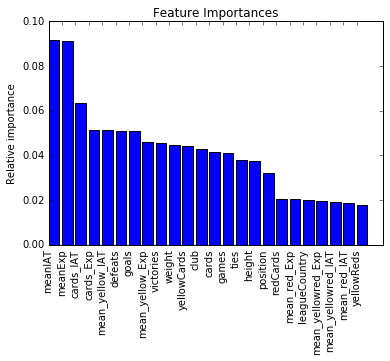

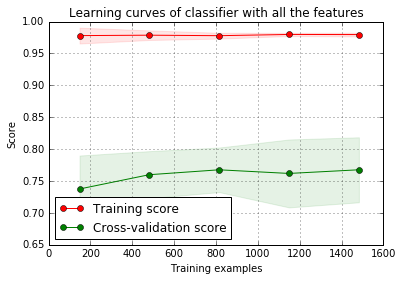

In [24]:
feat_to_keep = data.columns # keep all data
# the default classifier has 10 trees and no max depth
build_classifier(data, feat_to_keep)

We obtained a mean accuracy of 76.8 ± 2.8 %. This can seem like a high accuracy, however the number of white subjects in our dataset is around 75%, therefore our results could not be due to a good classification but to a bias in the classes. 
We can see that the most significant features in our classifier are the mean IAT and the mean Exp scores of the referees that a given player has faced. 
Some insights about our model can be gained with the training curves. We can see that the training score is consistenly above the test (cross-validation) score, and these don't vary much with an increasing number of training samples. Taken together, this means that our model overfits and is not able to generalize properly to unseen data. 

The features given to this classifier as an input are redundant, as some of them have been obtained as simple linear combinations of others. Therefore the next step is to carefully select the features.

#### Classify all features while varying the maximum depth and keeping nb trees fixed

max_depth = 5

0.772758451739 0.0160345425398


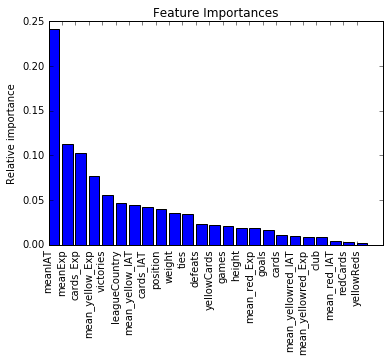

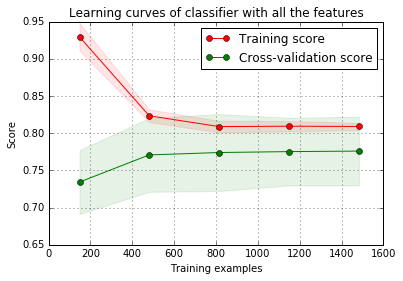

In [25]:
feat_to_keep = data.columns # keep all data
max_depth = 5
build_classifier(data, feat_to_keep, max_depth)

max_depth = 10

0.775886003593 0.0290859036994


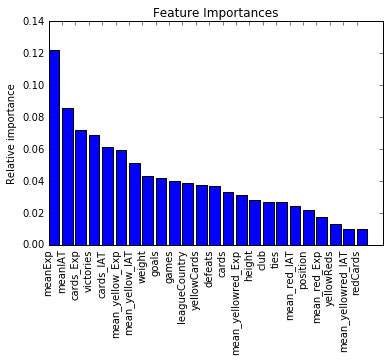

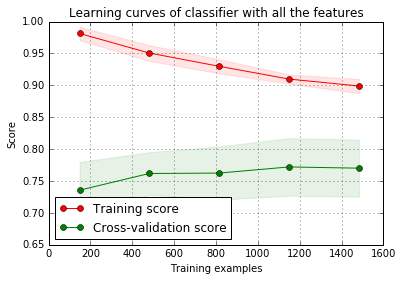

In [27]:
feat_to_keep = data.columns # keep all data
max_depth = 10
build_classifier(data, feat_to_keep, max_depth)

max_depth corresponds to the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

Changing the value of the max_depth parameter of the Random forest classifier does not seem to affect the cross-validation score. But it has a bigger impact on the training score, reducing the presence of overfitting.
Larger the maximum depth, more sign of overfitting observable.
A maximum depth of 5 seems to be the most relevant in our case.

#### Classify all features while varying the number of trees and keeping maximum depth fixed

nb_trees = 5

0.736248570962 0.0328430170463


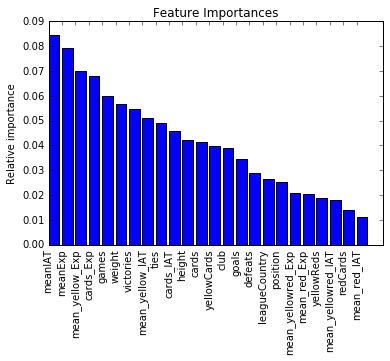

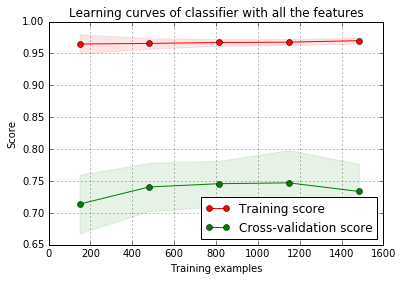

In [28]:
feat_to_keep = data.columns # keep all data
nb_trees = 5
max_depth = None
build_classifier(data, feat_to_keep, max_depth, nb_trees)

nb_trees = 50

0.778503184713 0.0347966796159


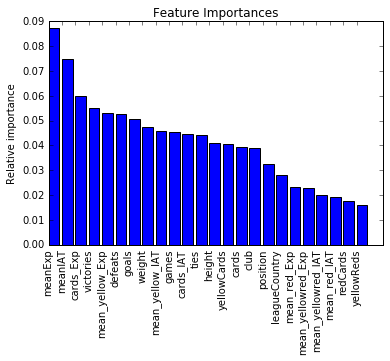

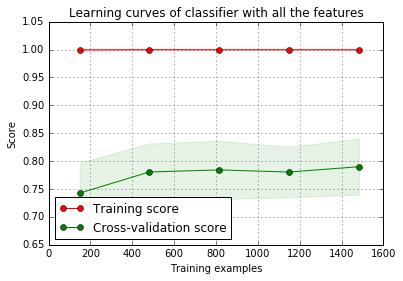

In [30]:
feat_to_keep = data.columns # keep all data
nb_trees = 50
max_depth = None
build_classifier(data, feat_to_keep, max_depth, nb_trees)

This time, changing the number of trees does not seem to affect the training score nor the overfitting problem. However, it has an impact on the cross-validation score. Increasing this number increases the cross-validation score up to a certain point, where increasing the number of trees does not seem to affect relevantly the cross-validation score anymore.
A number of trees around 50 seems to be relevant in our case.

For now on, a maximum depth of 5 and a number of trees of 50 will be used

0.7772129675 0.0546080505163


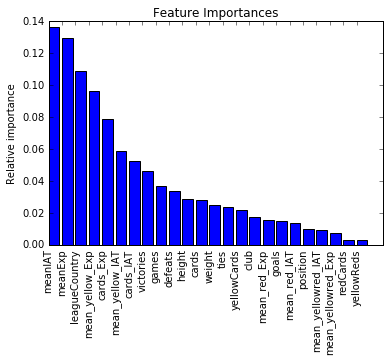

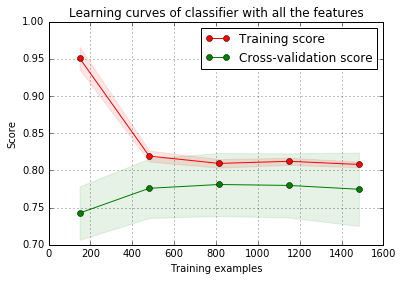

In [32]:
feat_to_keep = data.columns # keep all data
nb_trees = 50
max_depth = 5
build_classifier(data, feat_to_keep, max_depth, nb_trees)

### Using different features combination

#### Classify on the features witout the ones we engineered, with all cards as separated features
   - keep only the mean IAT and Exp of the judges and not their sum ponderated with the cards
   - keep the yellow , red and yellowred as separated numbers

0.770790462192 0.0321286806902


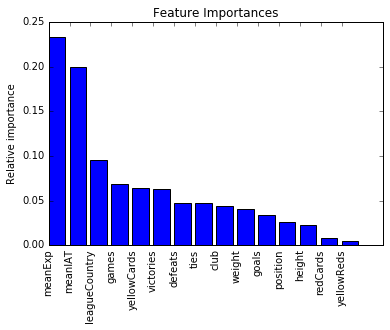

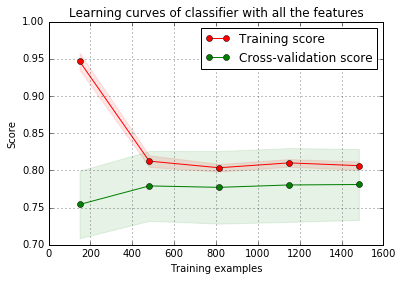

In [33]:
feat_to_keep = ['club', 'leagueCountry', 'position', 'height', 'weight', 'meanIAT', 'meanExp', 'games', 'victories', 'ties', 
        'defeats', 'goals', 'yellowCards', 'yellowReds' , 'redCards']
nb_trees = 50
max_depth = 5

build_classifier(data, feat_to_keep, max_depth, nb_trees)

Removing the engineered features does not seem to affect much the classification. The accuracy is quite equivalent to the one found with all the features and the standard deviation is even smaller.The features engineered might not bringing more relevant information. 
Keeping less features leads a less complex model, this is why we won't consider them.

#### Keep only the 14 first features from feature importance of classification (nb_trees = 50, max_depth = 5)

0.777196635636 0.0352280862178


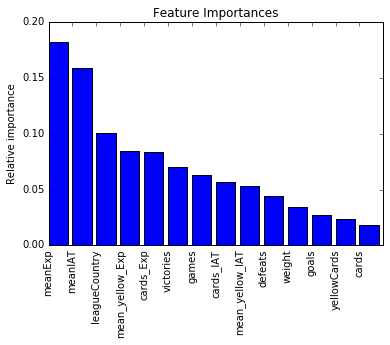

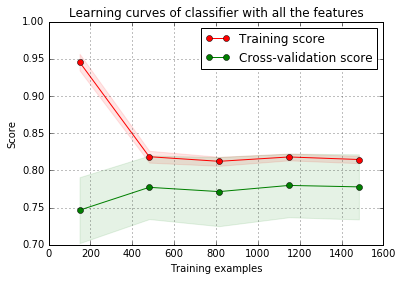

In [35]:
feat_to_keep = ['leagueCountry', 'weight', 'meanIAT', 'meanExp', 'games', 'victories', 'defeats','goals', 'yellowCards', 
              'mean_yellow_IAT','mean_yellow_Exp', 'cards', 'cards_IAT', 'cards_Exp']
nb_trees = 50
max_depth = 5

build_classifier(data, feat_to_keep, max_depth, nb_trees)

A model with more features is more complex. When dropping the less important features and keeping only the 14 first ones, a slight improvement in accuracy can be seen, which shows that it is not necessary to keep all of them.

#### Keep only the 3 first features from feature importance of classification (nb_trees = 50, max_depth = 5)

0.775298056508 0.0293494151558


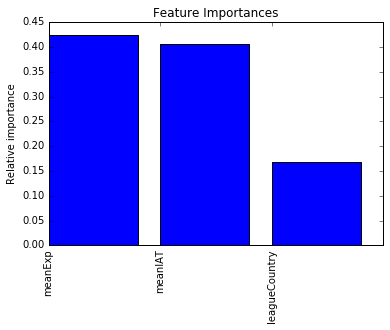

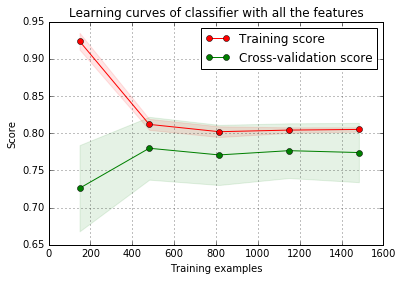

In [44]:
feat_to_keep = ['leagueCountry','meanIAT', 'meanExp']
nb_trees = 50
max_depth = 5

build_classifier(data, feat_to_keep, max_depth, nb_trees)

We obtain an accuracy 77.5 ± 2.9 % when using only the three first most relevant features in our classifier. This is only slightly below the result foudn for the best 14 features. Therefore our classification doesn't improve considerably by using a much larger number of features. 

#### Keep only the 3 less relevant features from feature importance of classification (nb_trees = 50, max_depth = 5)

In order to further study the results given by the feature importances function, we trained a classifier with the three least relevant features, and compared it to that obtained for the three most relevant features. 

0.756712395884 0.0199574202121


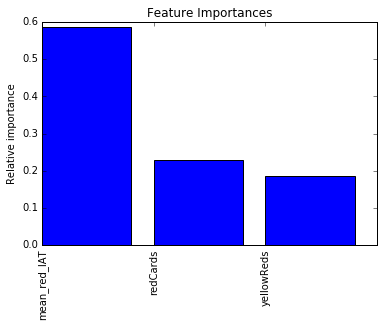

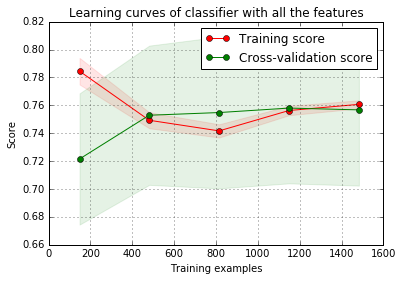

In [43]:
feat_to_keep = ['yellowReds','redCards','mean_red_IAT']
nb_trees = 50
max_depth = 5

build_classifier(data, feat_to_keep, max_depth, nb_trees)

We obtain, 75.7 ± 2.0 % , a lower test accuracy than the one obtained for the three most relevant features. Importantly, our training error is significantly lower in this case, proving the fact that the three most relevant features are more descriptive in our model than the three least relevant ones.

## Exercise 2: Cluster soccer players into two classes

In this part we want to cluster the player in an unsupervised manner, and see if the data is clustered by skin color. 
We use K-means for this clustering. We compute the silouhette score of the clustered data, that reflects the godness of the clustering. We also compute the accuracy of the clustering with respect to the labels corresponding to the skin color. A good silouhette score will mean that the data is well clustered, and a good accuracy will mean that these clusters correspond to skin color.

We want to cluster the data with respect to different features, removing them iteratively.
To do so, we start by ordering the features with respect to their importance for the classifier previously defined. Hence we build a new classifier, with all the features and get the order of features importance. We them remove iteratively the features, starting from the worst one.

In [56]:
# Build the classifier with default parameters: all the features we built
classifier = RandomForestClassifier(max_depth = 5, n_estimators = 50) 

# Define the features matrix
feat_to_keep = data.columns
features, feat_indexes = define_feat(data, feat_to_keep)
accuracy, classifier = build_RF(10,features,y, classifier)

#cluster the data into 2 groups with K-means
kmeans = KMeans(n_clusters=2).fit_predict(features)

In [57]:
# Remove the features iteratively and return the silouhette scores

# 1st order the features using the order of importance found by the previous classifier
feat_imp = classifier.feature_importances_
indices = np.argsort(feat_imp)[::-1]
labels = data.columns[indices]

accuracy=[]
sil_score=[]
for i in range(len(labels),0,-1):
    feat_to_keep=labels[0:i]
    features, feat_indexes=define_feat(data, feat_to_keep)

    #cluster the data into 2 groups with K-means
    kmeans = KMeans(n_clusters=2).fit_predict(features)
    accuracy.append(float(sum(y==kmeans))/float(len(y)))
    
    #compute the silouhette score
    sil_score.append(silhouette_score(features,kmeans))

# when the accuracy is <0.5 it means that the labels were attributed to the wrong group (as Kmeans attributes the labels to both group randomly)
# the real accuracy is then 1-accuracy:
accuracy = np.array(accuracy)
accuracy[accuracy<0.5]=1-accuracy[accuracy<0.5]
    

#### Plot the accuracy and the silouhette score for each set of features tested

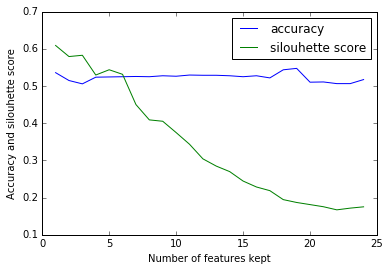

In [58]:
plt.figure()
plt.plot(range(len(labels),0,-1),accuracy, label='accuracy')
plt.plot(range(len(labels),0,-1),sil_score, label='silouhette score')
plt.legend()
plt.xlabel('Number of features kept')
plt.ylabel('Accuracy and silouhette score')

We see that the accuracy is always low (around 50%), which means that with this unsupervised clustering we never managed to cluster the people regarding their skin color. There is no pattern in the players population that directly reflects the skin color.
The silouhette score is higher when we use few features: the data is better clustered when we only look at a few component. There might be less overlap between clusters when there is less dimensions used.

The best combination of feature for clustering is the one with the higher silouhette score: 
We can find it:

In [61]:
#best combination of features: find the maximum accuracy 
best_features=labels[0:len(labels)-np.where(sil_score==max(sil_score))[0][0]]
best_features

Index(['meanExp'], dtype='object')

#### Progressively remove features in a random order (not from most to least relevant)

In [64]:
# remove the features iteratively and return the silouhette scores

accuracy=[]
sil_score=[]
for i in range(len(labels),0,-1):
    feat_to_keep=data.columns[0:i]
    features, feat_indexes=define_feat(data, feat_to_keep)

    #cluster the data into 2 groups with K-means
    kmeans = KMeans(n_clusters=2).fit_predict(features)
    accuracy.append(float(sum(y==kmeans))/float(len(y)))
    
    #compute the silouhette score
    sil_score.append(silhouette_score(features,kmeans))

# when the accuracy is <0.5 it means that the labels were attributed to the wrong group (as Kmeans attributes the labels to both group randomly)
# the real accuracy is then 1-accuracy:
accuracy = np.array(accuracy)
accuracy[accuracy<0.5]=1-accuracy[accuracy<0.5]

C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Maria\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


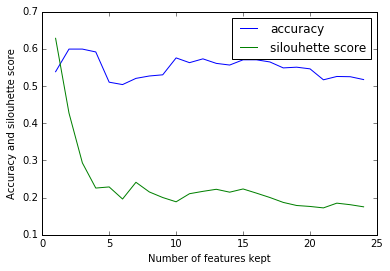

In [65]:
plt.figure()
plt.plot(range(len(labels),0,-1),accuracy, label='accuracy')
plt.plot(range(len(labels),0,-1),sil_score, label='silouhette score')
plt.legend()
plt.xlabel('Number of features kept')
plt.ylabel('Accuracy and silouhette score')

In [66]:
best_features=labels[0:len(labels)-np.where(sil_score==max(sil_score))[0][0]]
best_features

Index(['club'], dtype='object')

When compared to the curve obtained above, where the features are obtained from most to least relevant to perform k-means, we see that here the silouhette score drops really quickly as the number of features increases. This is to be expected, since k-means doesn't perform well in high dimensions, where samples are scarce and are located far away from each other.